In [96]:
import os
import types

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import BertTokenizer
from datasets import load_dataset

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation, LayerGradientXActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

from lm import LanguageModel

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");

# fine-tuned model checkpoint path
ckpt_path = 'Models/stf BSST-138/checkpoints/epoch=2-step=1481.ckpt'
# load model
model = LanguageModel.load_from_checkpoint(checkpoint_path=ckpt_path, num_classes=2)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [112]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)
    
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

In [113]:
# build sample dataset
data = load_dataset('hate_speech18')
# let's take an instance from the dataset
subset = data['train'][0:5]
text = subset['text'][2]
ground_truth = subset['label'][2]

Using custom data configuration default
Reusing dataset hate_speech18 (C:\Users\jzcha\.cache\huggingface\datasets\hate_speech18\default\0.0.0\8033f254483a20d1d10b0f1b56ded1f54326b1617872c537f354a721a6951d47)


In [114]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [115]:
output_attentions_all = torch.stack(output_attentions)

In [116]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [117]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores)), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [118]:
layer = 0

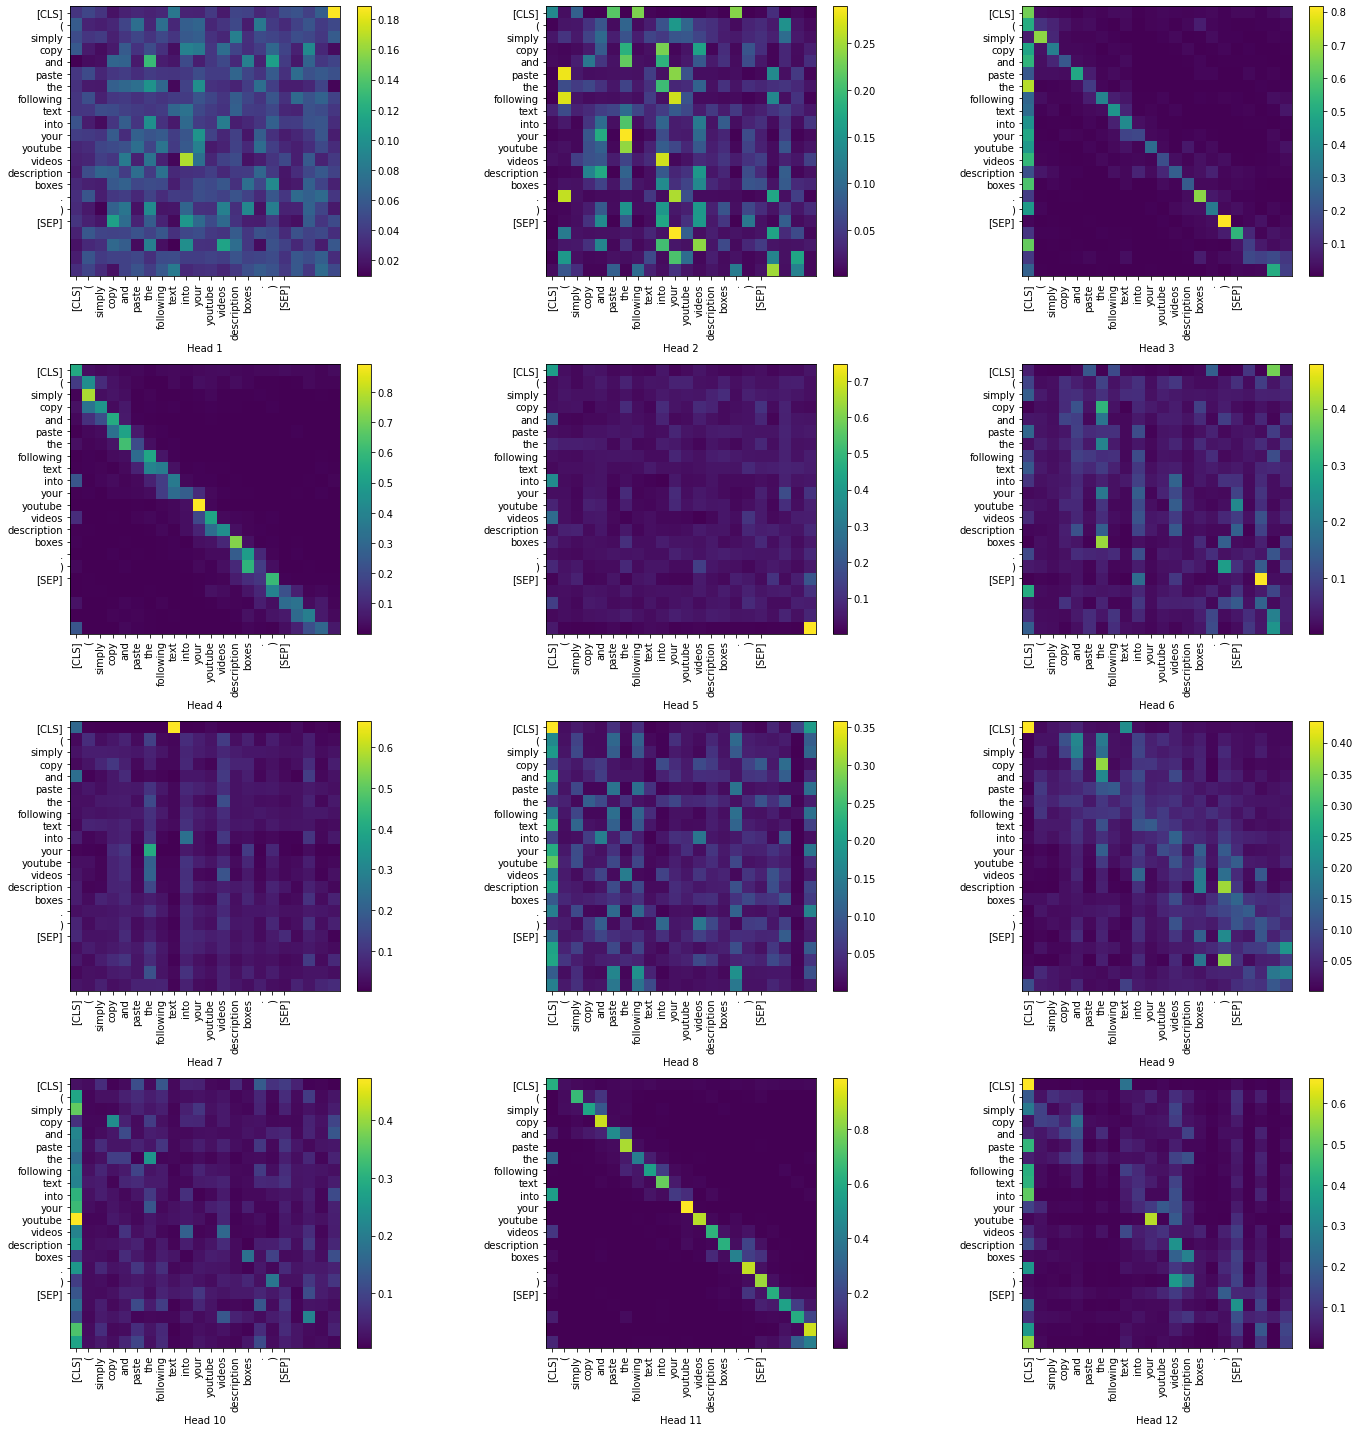

In [119]:
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

In [120]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

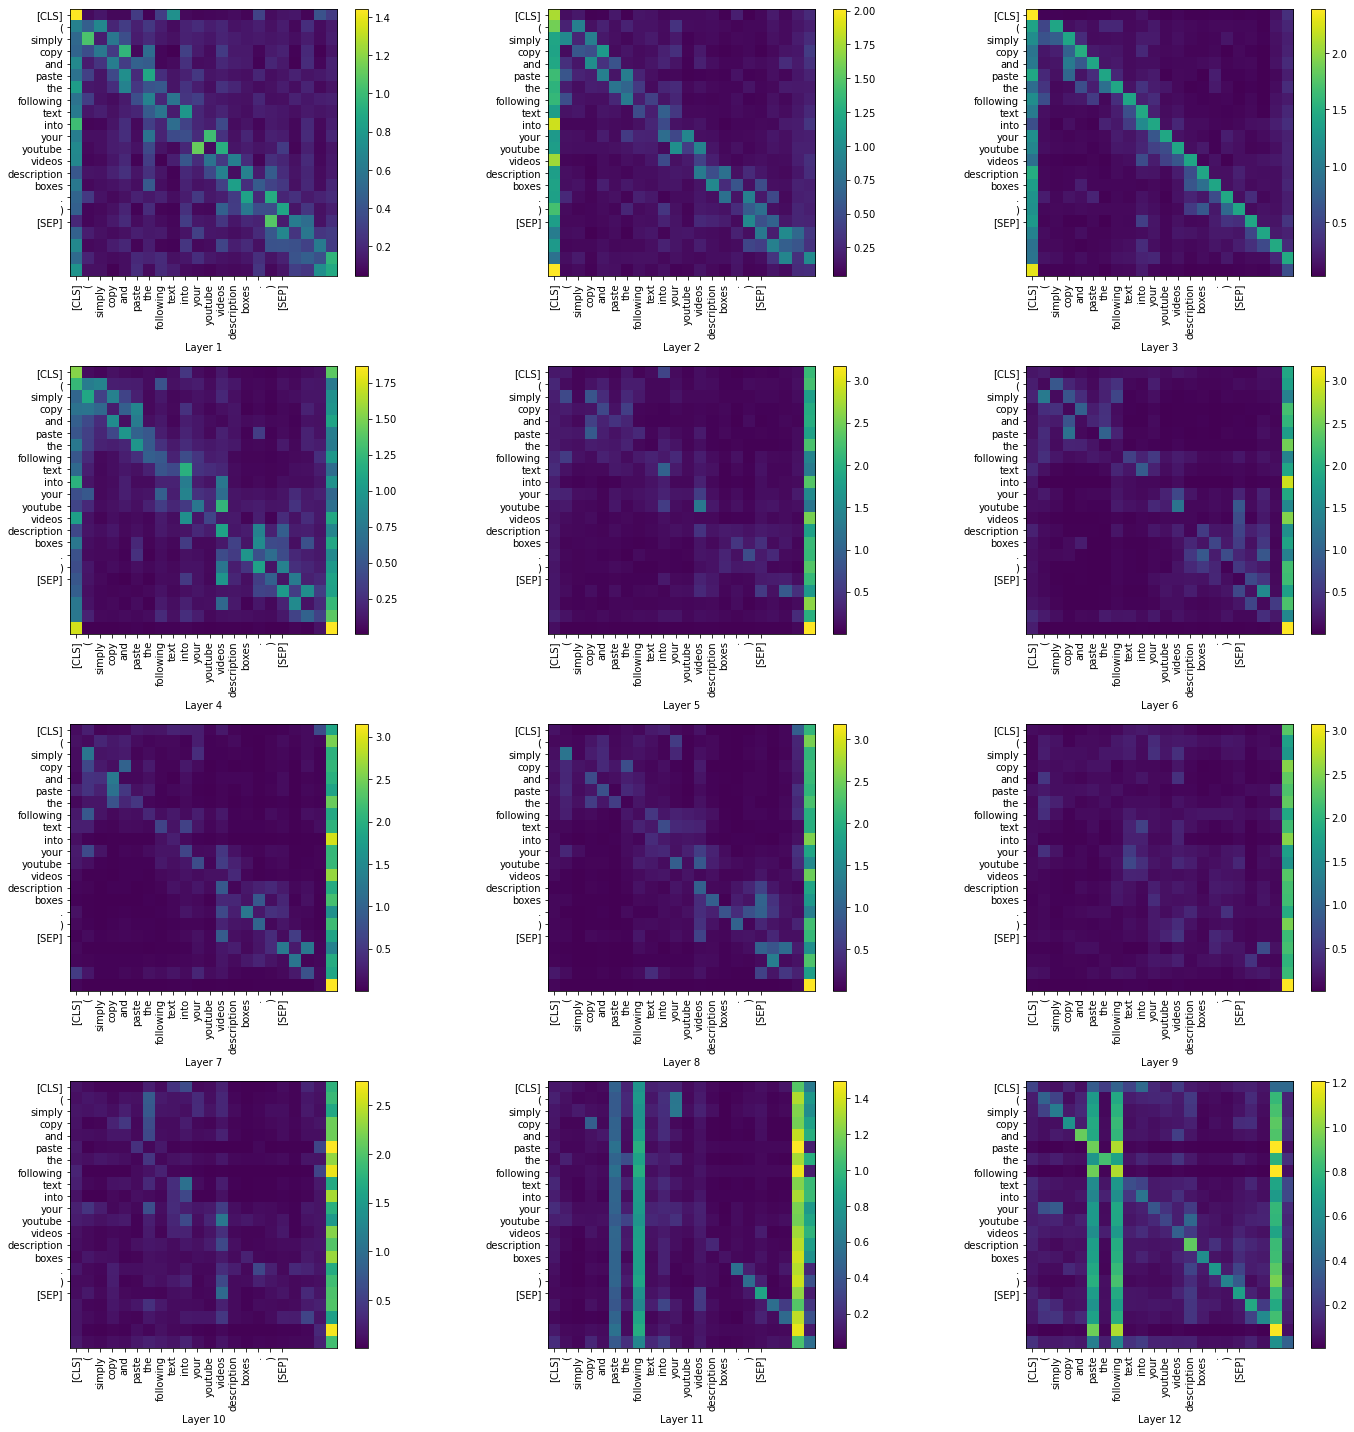

In [121]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), x_label_name='Layer')

In [122]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

In [123]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'classifier.bert.embeddings.word_embeddings')

AssertionError: InterpretableEmbeddingBase has already been configured for layer classifier.bert.embeddings.word_embeddings

In [ ]:
def forward_func(input_embeddings, attention_mask=None):
    logits, attn = model(input_ids=input_emb, attention_mask=attention_mask, embed=True)
    return logits

In [ ]:
layer_attrs = []
layer_attn_mat = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids)

for i in range(model.classifier.config.num_hidden_layers):
    lc = LayerGradientXActivation(forward_func, model.classifier.bert.encoder.layer[i])
    layer_attributions = lc.attribute(
        inputs = input_embeddings,
        target = torch.tensor(ground_truth).cuda().long(),
        additional_forward_args=(attention_mask))
    layer_attrs.append(summarize_attributions(layer_attributions[0]))
    layer_attn_mat.append(layer_attributions[1])


RuntimeError: The size of tensor a (18) must match the size of tensor b (768) at non-singleton dimension 2

In [ ]:
# layer x seq_len
layer_attrs = torch.stack(layer_attrs)

# layer x batch x head x seq_len x seq_len
layer_attn_mat = torch.stack(layer_attn_mat)

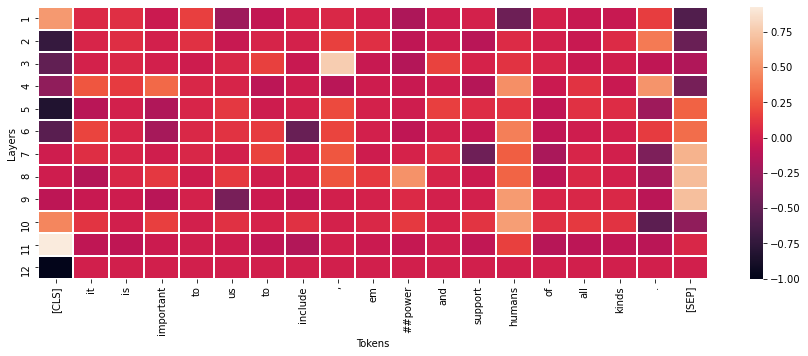

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

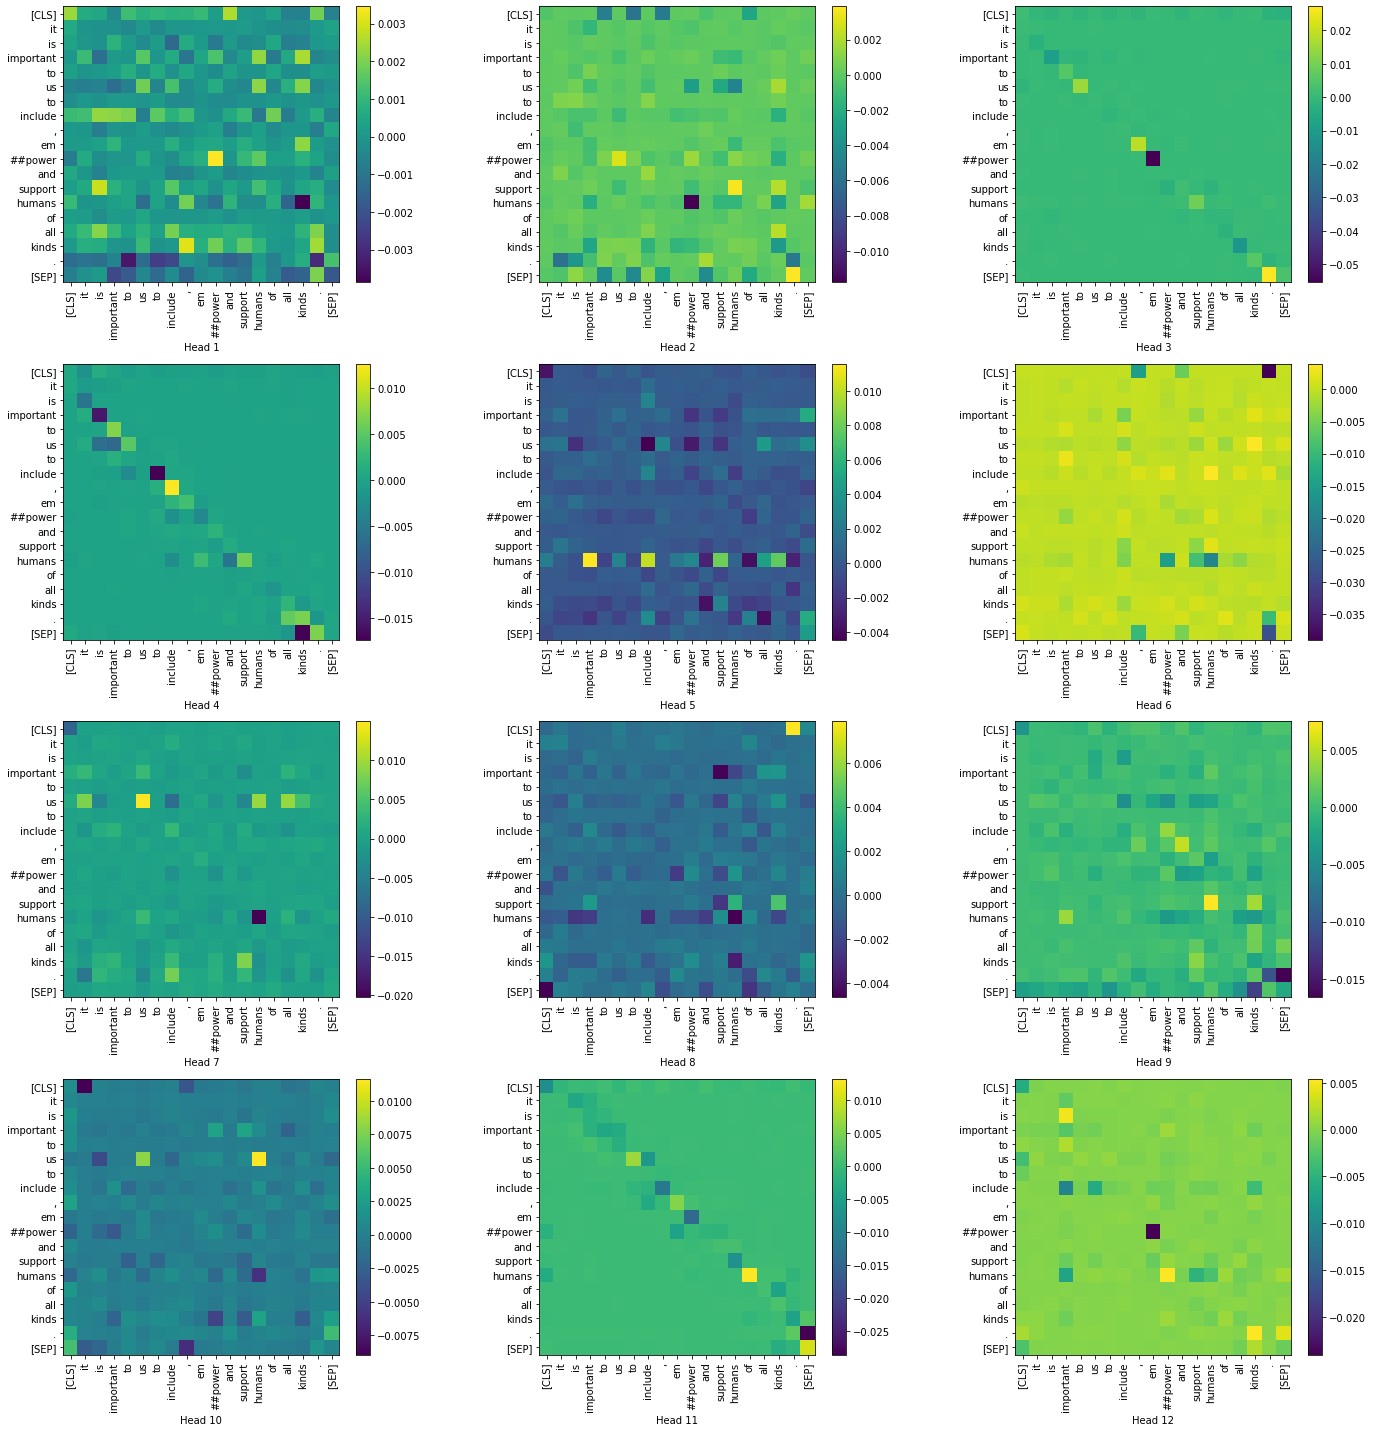

In [ ]:
visualize_token2token_scores(layer_attn_mat[layer].squeeze().cpu().detach().numpy())

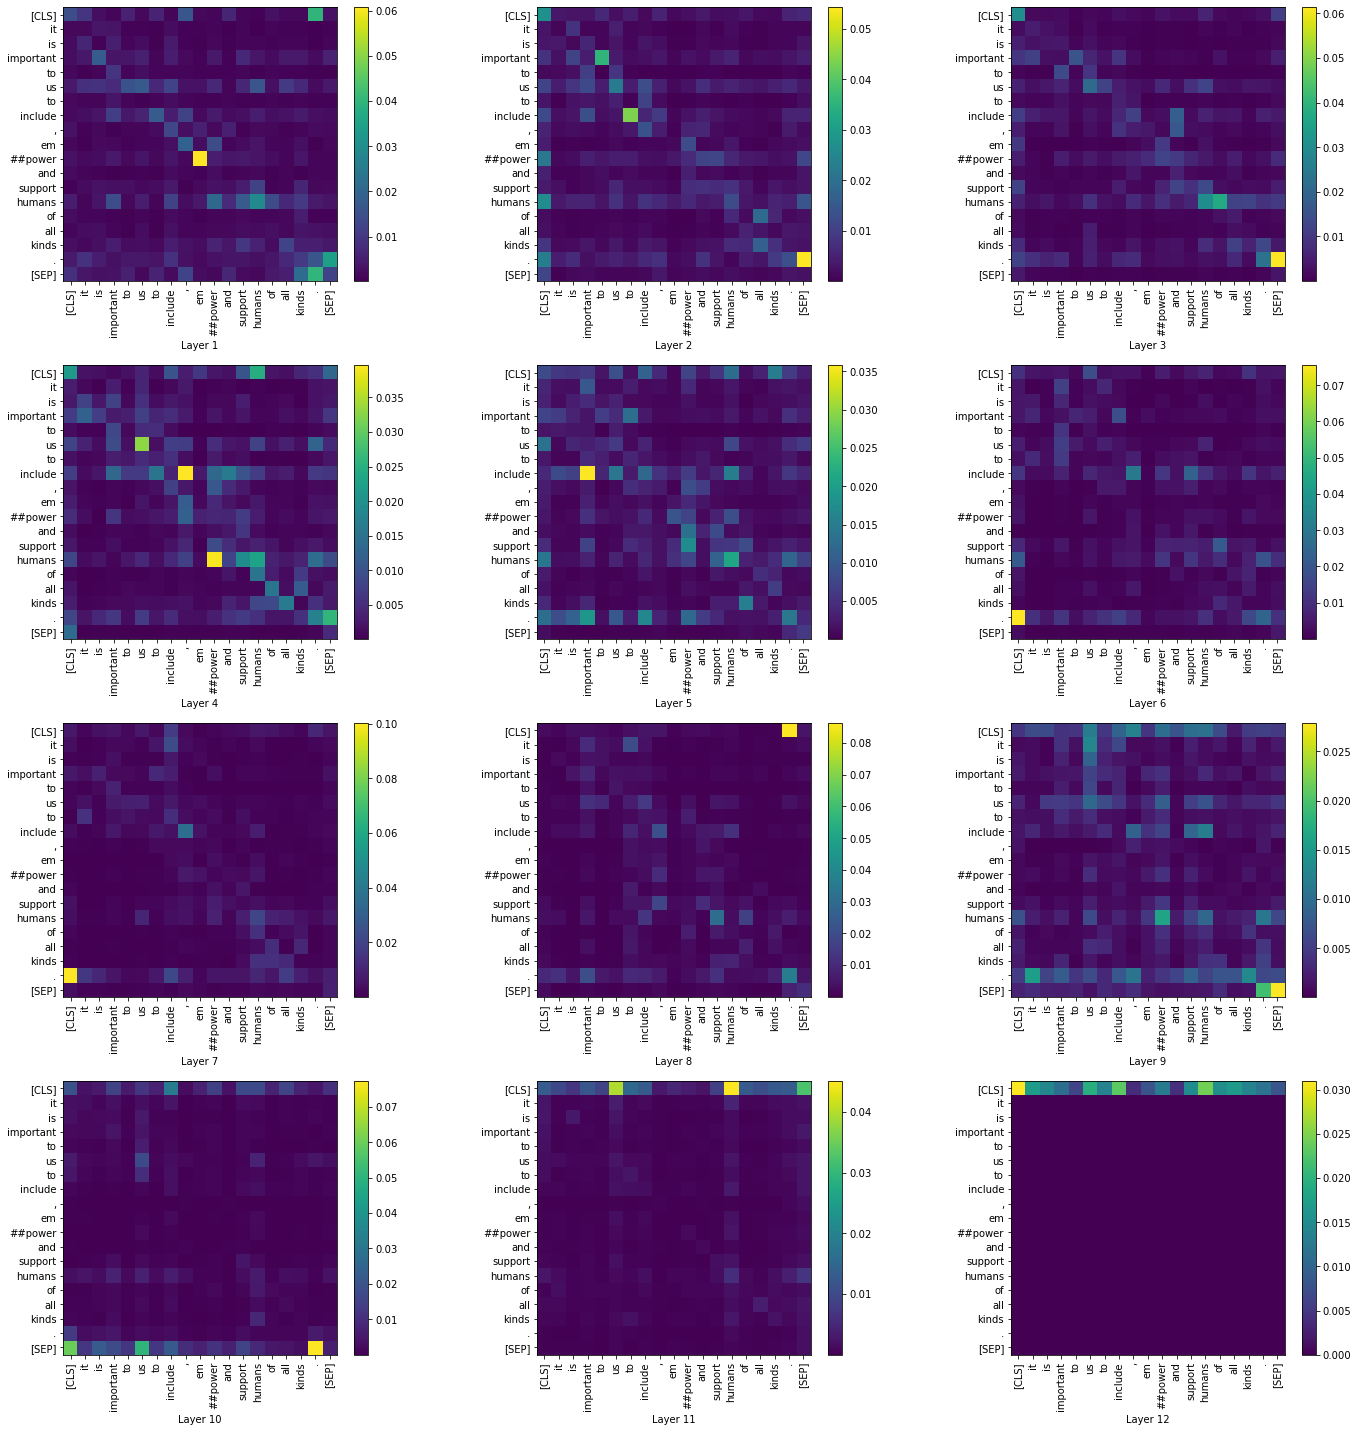

In [ ]:
visualize_token2token_scores(norm_fn(layer_attn_mat, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

In [ ]:
output_attentions_all_shape = output_attentions_all.shape

batch = output_attentions_all_shape[1]
num_heads = output_attentions_all_shape[2]
head_size = 64
all_head_size = 768

In [ ]:
layers = [model.classifier.bert.encoder.layer[layer].attention.self.value for layer in range(len(model.classifier.bert.encoder.layer))]

In [ ]:
la = LayerActivation(forward_func, layers)

value_layer_acts = la.attribute(input_embeddings, additional_forward_args=(attention_mask))
# shape -> layer x batch x seq_len x all_head_size
value_layer_acts = torch.stack(value_layer_acts)

In [ ]:
new_x_shape = value_layer_acts.size()[:-1] + (num_heads, head_size)
value_layer_acts = value_layer_acts.view(*new_x_shape)

# layer x batch x neum_heads x 1 x head_size
value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4)

value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4).contiguous()
value_layer_acts_shape = value_layer_acts.size()

# layer x batch x seq_length x num_heads x 1 x head_size
value_layer_acts = value_layer_acts.view(value_layer_acts_shape[:-1] + (1, value_layer_acts_shape[-1],))

print('value_layer_acts: ', value_layer_acts.shape)

value_layer_acts:  torch.Size([12, 1, 19, 12, 1, 64])


In [ ]:
dense_acts = torch.stack([dlayer.attention.output.dense.weight for dlayer in model.classifier.bert.encoder.layer])

dense_acts = dense_acts.view(len(layers), all_head_size, num_heads, head_size)

# layer x num_heads x head_size x all_head_size
dense_acts = dense_acts.permute(0, 2, 3, 1).contiguous()

In [ ]:
# layers, batch, seq_length, num_heads, 1, all_head_size
f_x = torch.stack([value_layer_acts_i.matmul(dense_acts_i) for value_layer_acts_i, dense_acts_i in zip(value_layer_acts, dense_acts)])
f_x.shape

torch.Size([12, 1, 19, 12, 1, 768])

In [ ]:
# layer x batch x seq_length x num_heads x 1 x all_head_size)
f_x_shape = f_x.size() 
f_x = f_x.view(f_x_shape[:-2] + (f_x_shape[-1],))
f_x = f_x.permute(0, 1, 3, 2, 4).contiguous() 

#(layers x batch, num_heads, seq_length, all_head_size)
f_x_shape = f_x.size() 

#(layers x batch, num_heads, seq_length)
f_x_norm = norm_fn(f_x, dim=-1)

f_x.size() 

torch.Size([12, 1, 12, 19, 768])

In [ ]:
test = f_x_norm.squeeze().detach().cpu().numpy()
for idx, scores in enumerate(test):

        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores)), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)

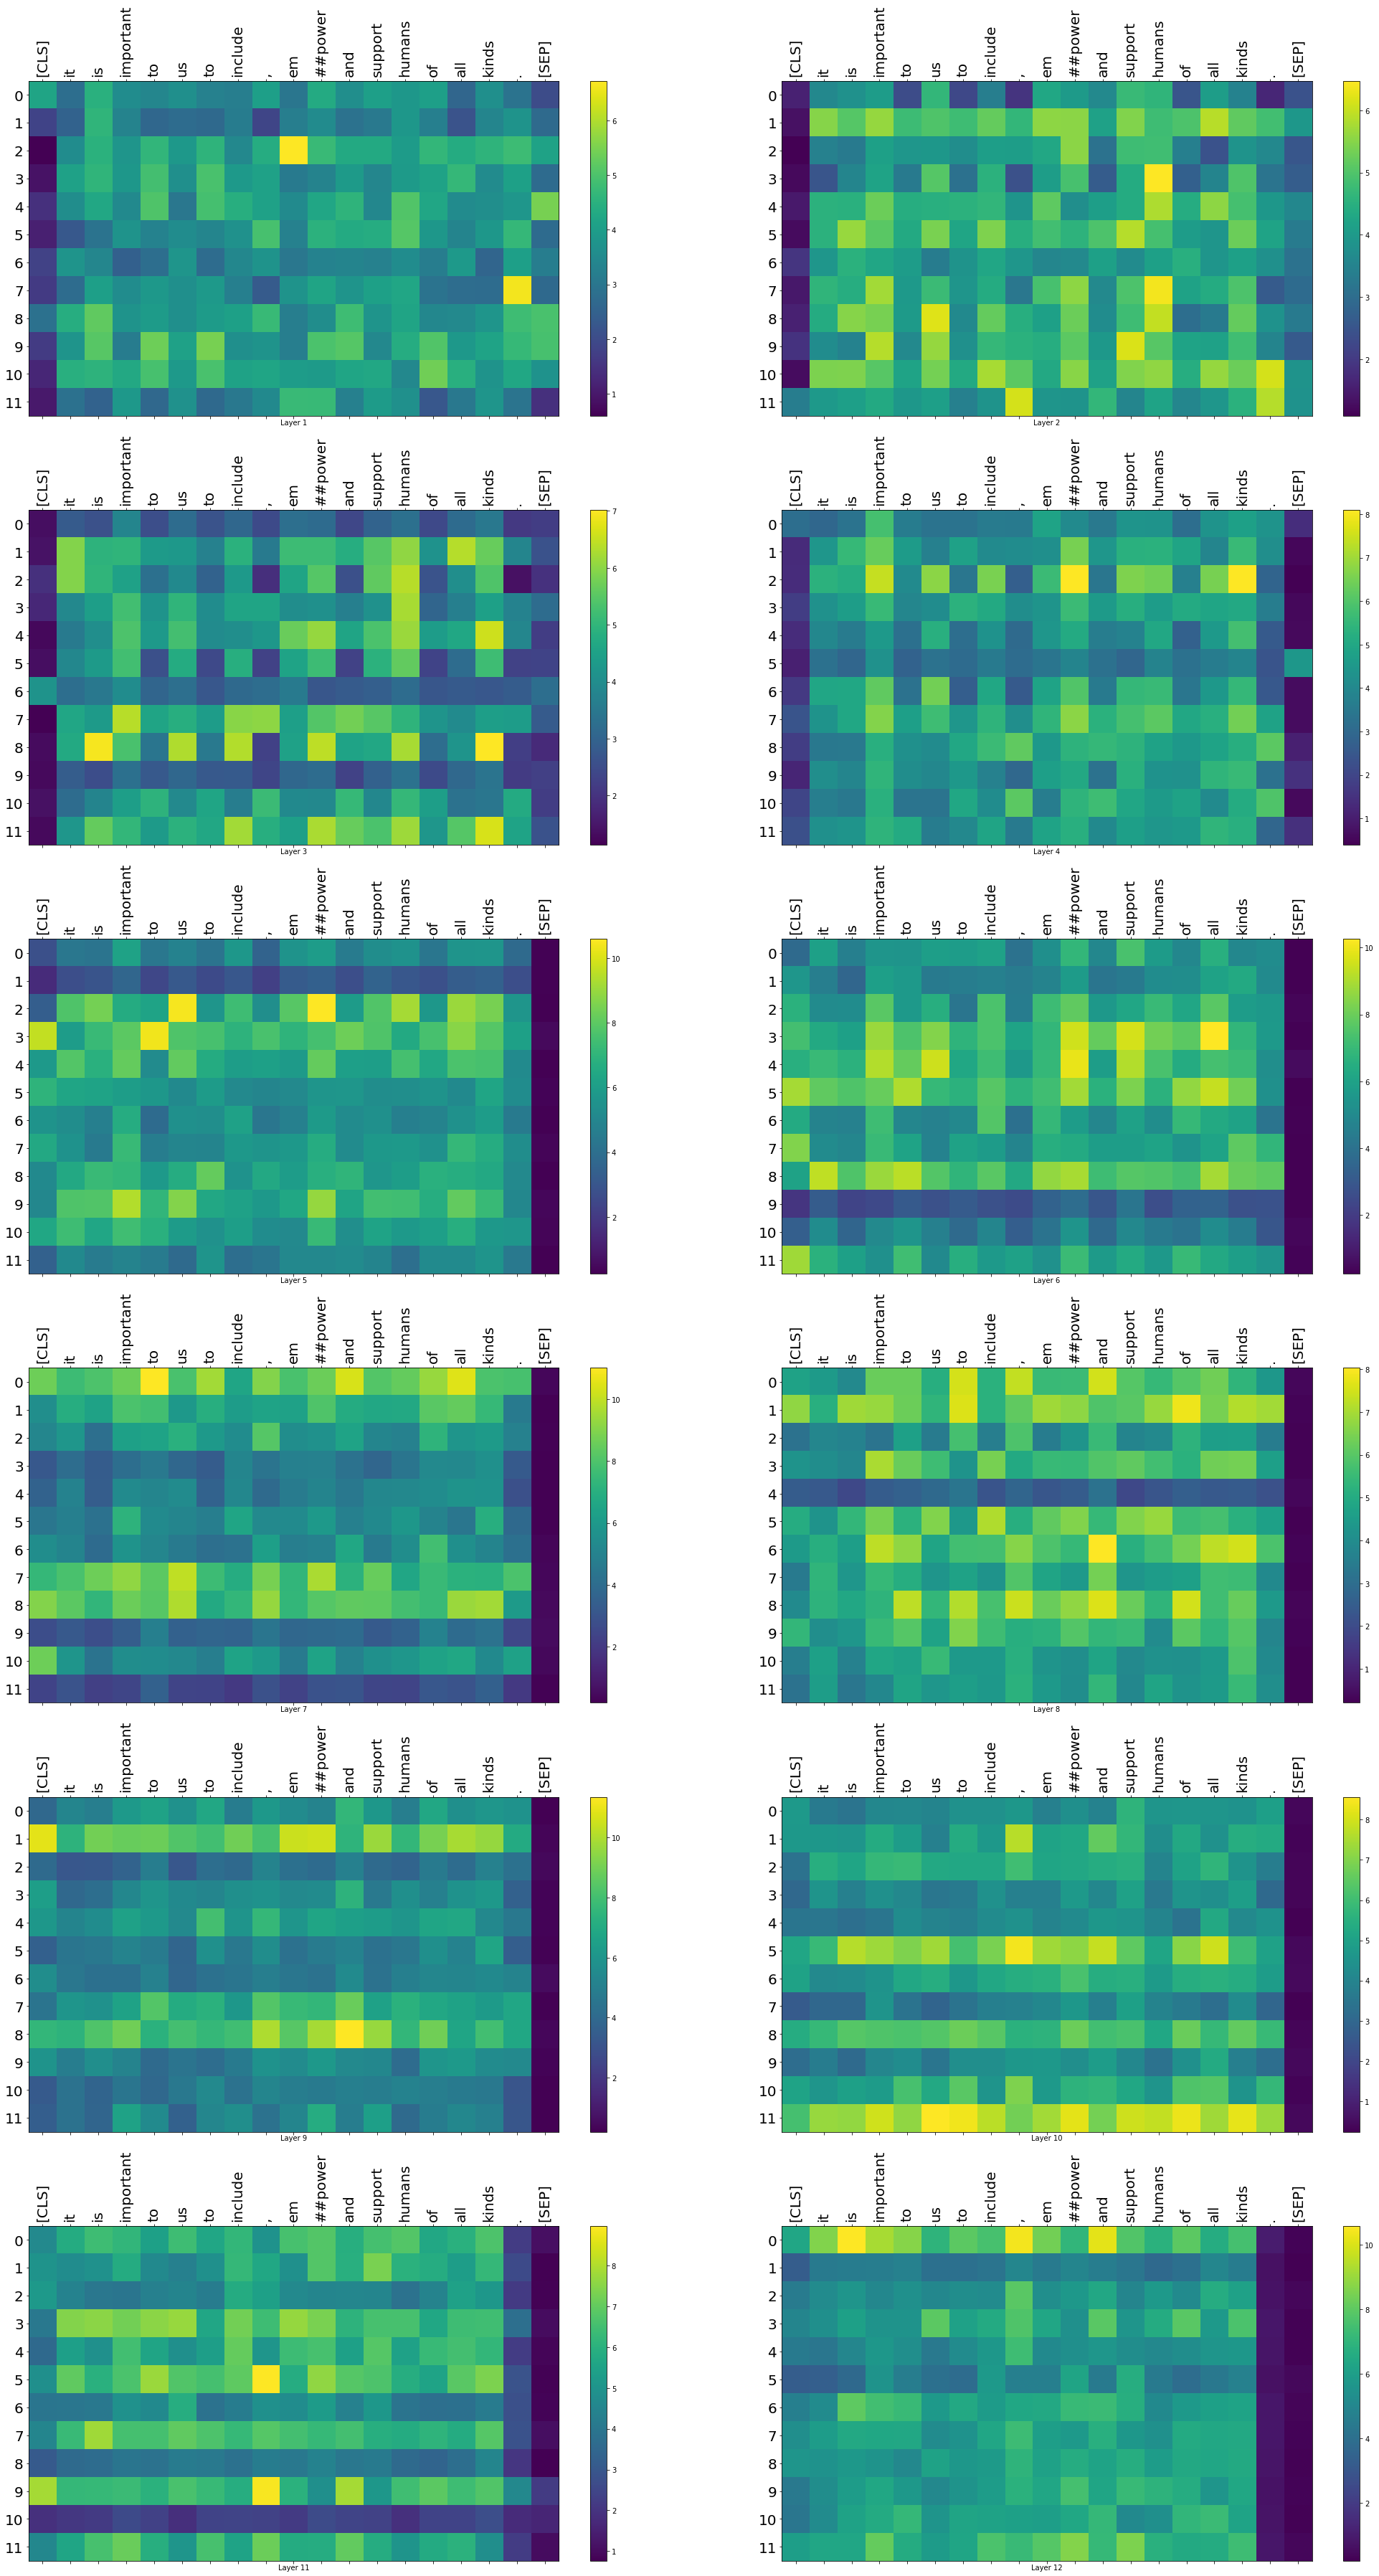

In [ ]:
visualize_token2head_scores(f_x_norm.squeeze().detach().cpu().numpy())


In [ ]:
# layer x batch x num_heads x seq_length x seq_length x all_head_size
alpha_f_x = torch.einsum('lbhks,lbhsd->lbhksd', output_attentions_all, f_x)

# layer x batch x num_heads x seq_length x seq_length
alpha_f_x_norm = norm_fn(alpha_f_x, dim=-1)

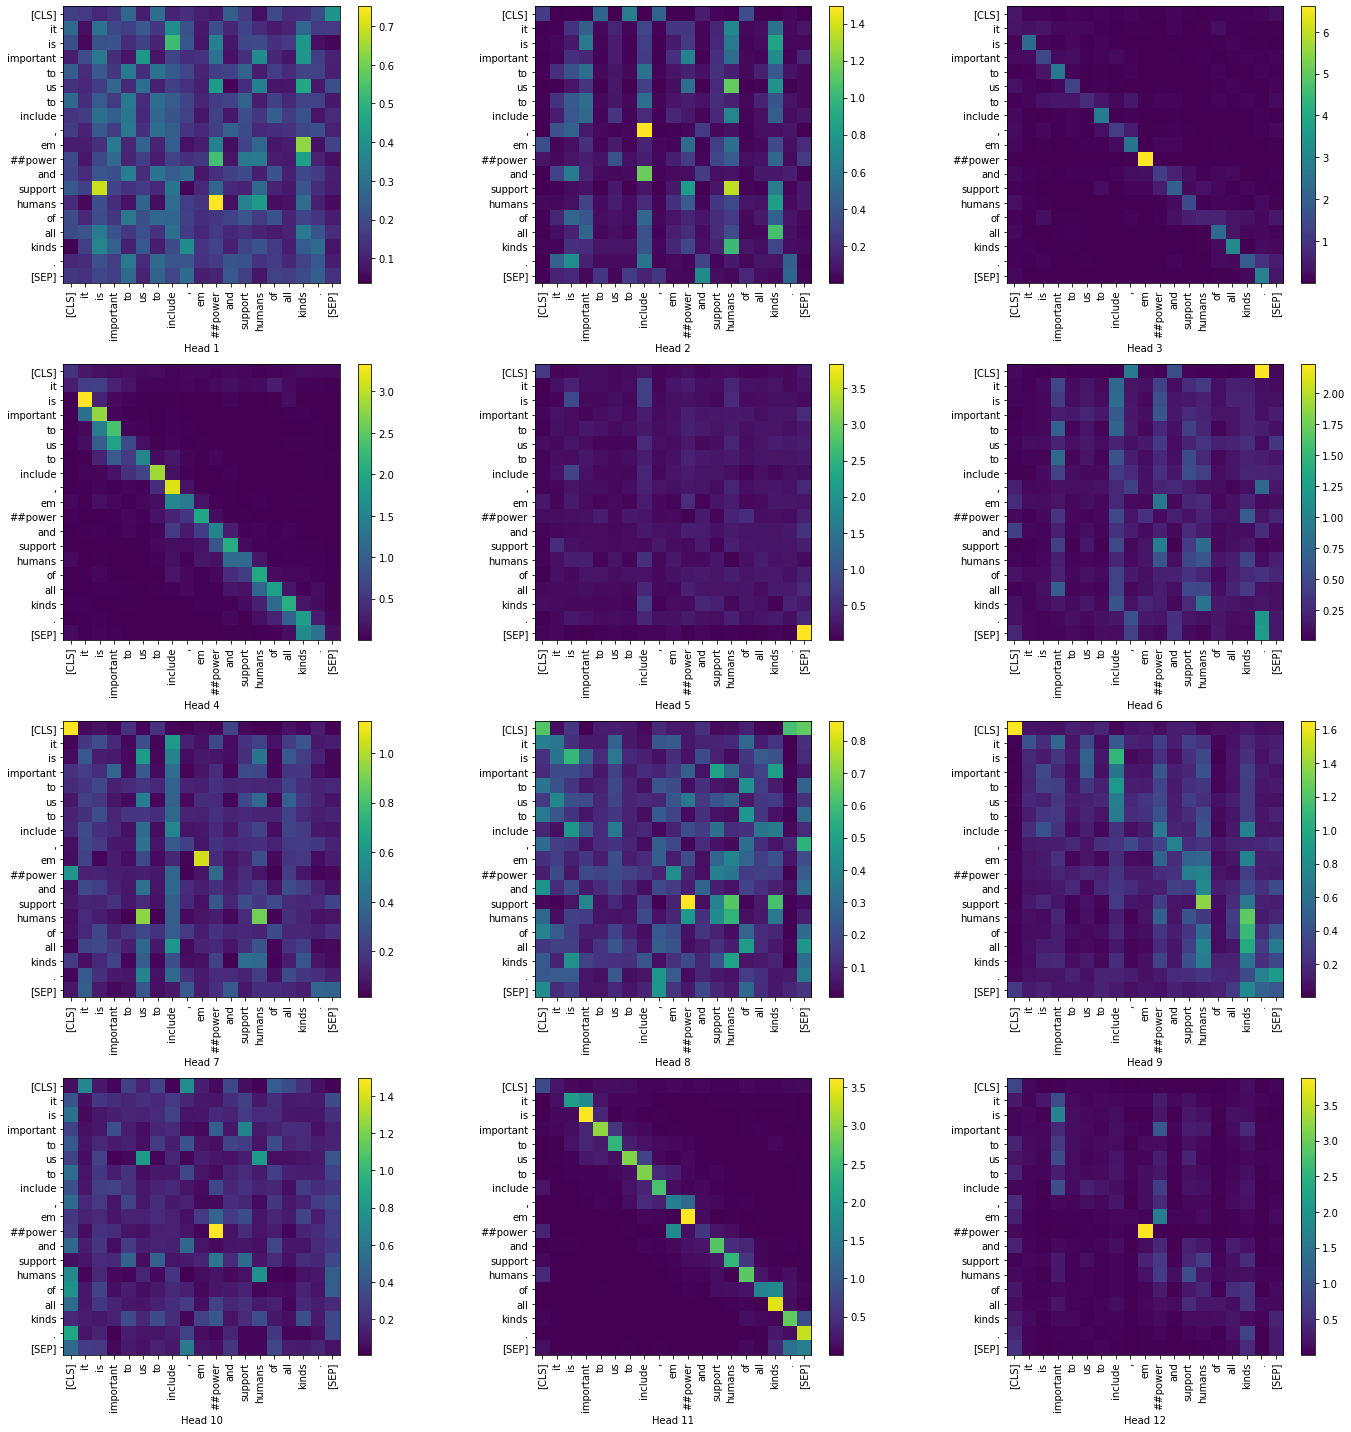

In [ ]:
visualize_token2token_scores(alpha_f_x_norm[layer].squeeze().detach().cpu().numpy())

In [ ]:
summed_alpha_f_x = alpha_f_x.sum(dim=2)

# layers x batch x seq_length x seq_length
summed_alpha_f_x_norm = norm_fn(summed_alpha_f_x, dim=-1)

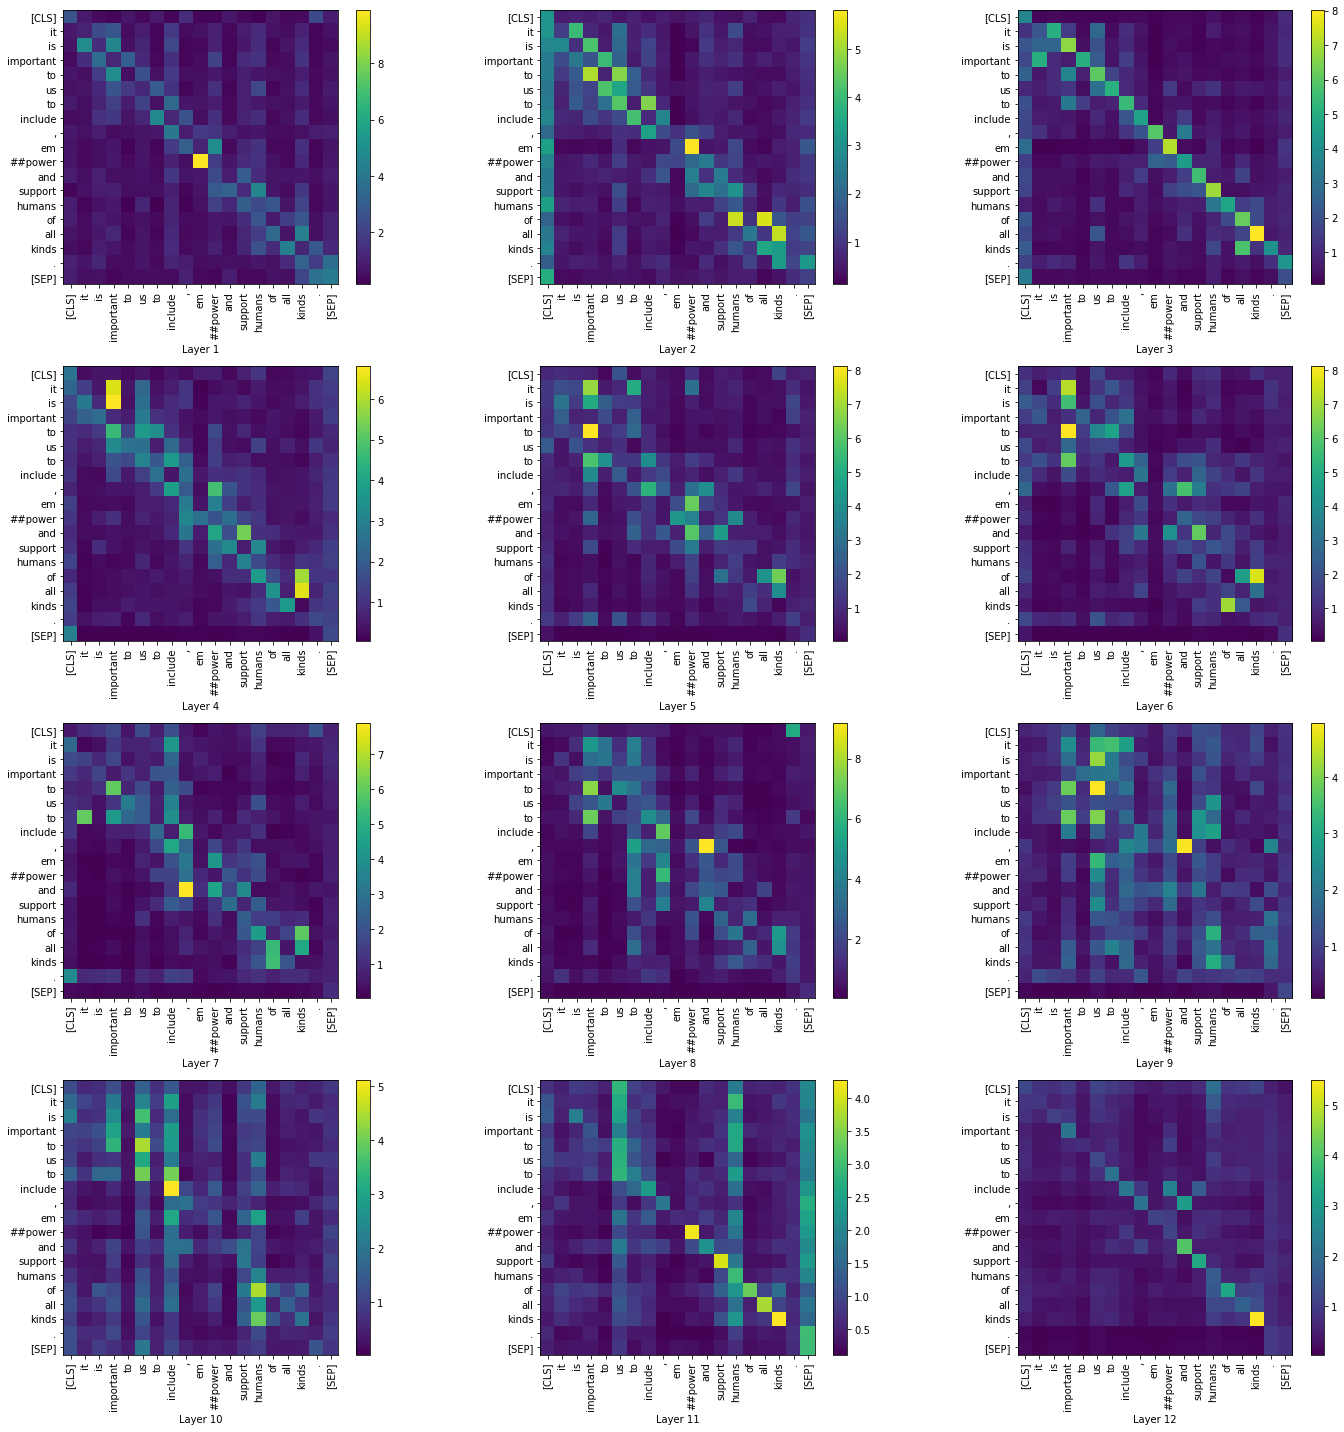

In [ ]:
visualize_token2token_scores(summed_alpha_f_x_norm.squeeze().cpu().detach().numpy(), x_label_name='Layer')